In [1]:
import numpy as np
import pandas as pd
import os
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import rasterio
from rasterio.transform import from_origin
from rasterio.crs import CRS
import gstools as gs
from geopy.distance import geodesic
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error
from scipy.interpolate import Rbf
from tqdm import trange
from scipy.spatial import cKDTree
import pytz
import warnings

pd.set_option('display.max_columns', None)

In [40]:
def hourly_to_daily(hourly_data_path, daily_save_path):
    warnings.filterwarnings("ignore", category=UserWarning, message="Could not infer format, so each element will be parsed individually")

    for m in trange(len(os.listdir(hourly_data_path)), desc="Files Processed: "):    
        prcp_hrly_file = os.listdir(hourly_data_path)[m]
        save_path = os.path.join(daily_save_path, prcp_hrly_file)
        prcp_hrly_file_pth = os.path.join(hourly_data_path, prcp_hrly_file)
        df = pd.read_excel(prcp_hrly_file_pth)

        # Ensure that the 'Date - Time' column is in datetime format
        df['Date - Time'] = pd.to_datetime(df['Date - Time'])

        # Drop rows where 'Rain(inches)' is NaN
        df = df.dropna(subset=['Rain(inches)'])

        # Convert CST to EST (handle daylight saving time using America/Chicago for CST)
        cst = pytz.timezone('America/Chicago')
        est = pytz.timezone('America/New_York')

        # Localize the timestamp to CST and then convert to EST
        df['timestamp_cst'] = df['Date - Time'].dt.tz_localize(cst, ambiguous=True)
        df['timestamp_est'] = df['timestamp_cst'].dt.tz_convert(est)

        # Set 'timestamp_est' as the DataFrame index
        df.set_index('timestamp_est', inplace=True)

        # Resample the data from 7 AM to 6 AM of the next day in EST, summing all precipitation values
        # Use '1D' to resample on a daily frequency, starting the day at 7 AM EST.
        daily_precipitation = df['Rain(inches)'].resample('1D', origin='epoch', offset='7h').sum()

        # **Shift the index one day backward** so the result is labeled with the previous day's date
        daily_precipitation.index = daily_precipitation.index

        daily_precipitation.index = daily_precipitation.index + pd.Timedelta(days=1)

        # Drop any values greater than 100inch of rain 
        if (daily_precipitation > 100).any().any():
            print(prcp_hrly_file)
        daily_precipitation[daily_precipitation > 100] = pd.NA

        # Convert the index to just the date (not datetime) after summing
        daily_precipitation.index = daily_precipitation.index.date

        # Reset the index so that the date becomes a column
        daily_precipitation = daily_precipitation.reset_index()

        # Rename the columns for clarity
        daily_precipitation.columns = ['Date', 'Daily Rain (inches)']

        # Save the daily precipitation data to a new file or display it
        daily_precipitation.to_excel(save_path, index=False)

In [ ]:
min15_data_path = "/home/arvinder/Downloads/Hydromet_Full_Record"
daily_save_path = "/home/arvinder/interpolation/Precipitation/15min_to_Daily_7EST"
hourly_to_daily(min15_data_path, daily_save_path)

In [7]:
def get_dataframe(data_path, latlon_path, start_date, end_date):
    # Initialize an empty dictionary to store dataframes and a list for site names
    data_dict = {}    
    common_index = pd.date_range(start=start_date, end=end_date)
    site_name = []

    # Iterate through each gauge directory in data_path
    for gauge in data_path:
        # Iterate through each file in the current gauge directory
        for file_name in os.listdir(gauge):
            # Append the file name to site_name list
            site_name.append(file_name.split(".xlsx")[0])
            file = os.path.join(gauge, file_name)
            
            # Read the Excel file into a dataframe
            df = pd.read_excel(file)
            
            # Check if the dataframe contains a "Date" column
            if "Date" in df.columns:
                # Convert "Date" column to datetime and set it as the index
                df["Date"] = pd.to_datetime(df["Date"])
                df.set_index("Date", inplace=True)
                
                # Read latitude and longitude data from latlon_path
                lat_lon_df = pd.read_excel(latlon_path)
                lat_lon_df.set_index("site_number", inplace=True)
                
                # Extract site number from the file name
                site_number = int(file_name.split("_")[0])
                
                # Get latitude and longitude for the current site number
                lat_lon = lat_lon_df.loc[site_number]
                latitude = float(lat_lon["Lat"])
                longitude = float(lat_lon["Long_"])
                lat_lon_tup = (latitude, longitude)
                
                # Reindex the dataframe to match the common date range
                df = df.reindex(common_index)
                df.reset_index(inplace=True)
                
                # Add the dataframe to the dictionary with the lat/lon tuple as the key
                data_dict[lat_lon_tup] = df
            else:
                # Rename columns if the dataframe does not have a "Date" column
                df.rename(columns={'DATE': 'Date', 'PRCP': 'Daily Rain (inches)', 'PRCP (in)': 'Daily Rain (inches)'}, inplace=True)
                
                # Convert "Date" column to datetime and set it as the index
                df["Date"] = pd.to_datetime(df["Date"])
                df.set_index("Date", inplace=True)
                
                # Extract latitude and longitude from the first row
                lat_lon = df.iloc[0]
                latitude = float(lat_lon["LATITUDE"])
                longitude = float(lat_lon["LONGITUDE"])
                
                # Drop unnecessary columns
                columns_to_delete = df.columns[:5]
                df.drop(columns=columns_to_delete, inplace=True)
                lat_lon_tup = (latitude, longitude)
                
                # Reindex the dataframe to match the common date range
                df = df.reindex(common_index)
                df.reset_index(inplace=True)
                
                # Add the dataframe to the dictionary with the lat/lon tuple as the key
                data_dict[lat_lon_tup] = df
    
    # Return the dictionary of dataframes and the list of site names
    return data_dict, site_name

In [8]:
prcp_path_hydromet = "/home/arvinder/interpolation/Precipitation/Hydromet"
# prcp_path_hydromet = "/home/arvinder/interpolation/Precipitation/Hourly_to_Daily_7EST"

hydromet_latlon_path = "/home/arvinder/interpolation/Precipitation/Hydromet Gage LatLong.xls"

prcp_path_NOAA = "/home/arvinder/interpolation/Precipitation/NOAA"
NOAA_latlon_path = "/home/arvinder/interpolation/Precipitation/NOAA Gage LatLong.xlsx"
LCRA_shp_pth = "/home/arvinder/interpolation/HUC4_1209/HUC4_1209.shp"

prism_shape_file_4km = "/home/arvinder/Downloads/prism_4km_mesh/prism_4km_mesh.shp"

start_date = '2007-01-01'
end_date = '2023-10-31'

# prcp_dict, site_names = get_dataframe([prcp_path_hydromet, prcp_path_NOAA], hydromet_latlon_path, start_date, end_date)
prcp_dict, site_names = get_dataframe([prcp_path_hydromet], hydromet_latlon_path, start_date, end_date)
prcp_coord = list(prcp_dict.keys())

In [ ]:
# Analyze data- Time distribution 

def data_time_distribution(prcp_dict):
    # Reindex dataframe with time indexing
    all_df = prcp_dict.values()
    all_df = [df.rename(columns={df.columns[0]: 'time'}) for df in all_df]
    all_df = [df.set_index('time') for df in all_df]

    # Drop nan values, Add (start, end) date to the list and then sort it on the basis of start date
    start_end = []
    for df in all_df:
        df = df.dropna()
        start_end.append((df.index.min(), df.index.max()))
    start_end = sorted(start_end, key=lambda x: (pd.isna(x[0]), x[0]))

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(15, 10), dpi=100)

    # Plot each interval as a horizontal bar
    for i, (start, end) in enumerate(start_end):
        ax.barh(i, (end - start).days, left=start, height=0.4, align='center')


    # Format the x-axis to show dates nicely
    ax.xaxis.set_major_locator(mdates.YearLocator())  # Set the major ticks to every 5 years
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)

    # Set labels and title
    ax.set_xlabel('Year')
    ax.set_ylabel('Station')
    ax.set_title('Data available for each station')

    # Show the plot
    plt.tight_layout()
    plt.show()

data_time_distribution(prcp_dict)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def data_time_distribution(prcp_dict):
    # Initialize a dictionary to store counts for each year-month
    coverage_dict = {}

    # Loop through each DataFrame in the dictionary
    for df in prcp_dict.values():
        df = df.rename(columns={df.columns[0]: 'time'})
        df.set_index('time', inplace=True)
        df = df.dropna()

        # Create a set to track unique year-month combinations for this station
        unique_months = set()

        # Count available months for the current station
        for date in df.index:
            year_month = date.to_period('M')  # Group by year and month
            unique_months.add(year_month)

        # Update the coverage dictionary based on unique months for this station
        for month in unique_months:
            if month not in coverage_dict:
                coverage_dict[month] = 0
            coverage_dict[month] += 1

    # Convert the coverage dictionary to a DataFrame
    coverage_df = pd.Series(coverage_dict).reset_index()
    coverage_df.columns = ['year_month', 'station_count']

    # Convert to string for pivoting
    coverage_df['year_month'] = coverage_df['year_month'].astype(str)

    # Pivot the DataFrame for heatmap
    coverage_pivot = coverage_df.pivot_table(index=coverage_df['year_month'].str[:4], 
                                               columns=coverage_df['year_month'].str[5:], 
                                               values='station_count', 
                                               fill_value=0)

    # Plotting the heatmap
    plt.figure(figsize=(12, 8))
    heatmap = sns.heatmap(coverage_pivot, cmap='Blues', annot=True, fmt='g', 
                          cbar=False)  # Turn off the color bar for now

    # Add the color bar manually and invert it
    cbar = plt.colorbar(heatmap.collections[0], pad=0.01)
    cbar.set_label('Number of Stations')
    cbar.ax.invert_yaxis()  # Invert the color bar

    plt.xlabel('Month')
    plt.ylabel('Year')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage:
data_time_distribution(prcp_dict)


In [ ]:
import matplotlib.colors as mcolors
import numpy as np

def plot_active_stations_fancy_v6(prcp_dict):
    # Initialize a dictionary to store counts for each year-month
    coverage_dict = {}

    # Loop through each DataFrame in the dictionary
    for df in prcp_dict.values():
        df = df.rename(columns={df.columns[0]: 'time'})
        df.set_index('time', inplace=True)
        df = df.dropna()

        # Create a set to track unique year-month combinations for this station
        unique_months = set()

        # Count available months for the current station
        for date in df.index:
            year_month = date.to_period('M')  # Group by year and month
            unique_months.add(year_month)

        # Update the coverage dictionary based on unique months for this station
        for month in unique_months:
            if month not in coverage_dict:
                coverage_dict[month] = 0
            coverage_dict[month] += 1

    # Convert the coverage dictionary to a DataFrame
    coverage_df = pd.Series(coverage_dict).reset_index()
    coverage_df.columns = ['year_month', 'station_count']

    # Convert to datetime for plotting
    coverage_df['year_month'] = pd.to_datetime(coverage_df['year_month'].astype(str))

    # Sort the DataFrame by year_month
    coverage_df.sort_values('year_month', inplace=True)

    # Create the figure and axis
    plt.figure(figsize=(14, 7))

    # Define a set of warm colors for the gradient
    colors = ['#fff7bc', '#fec44f', '#fe9929', '#ec7014', '#cc4c02', '#993404']
    cmap = mcolors.LinearSegmentedColormap.from_list("warm_gradient", colors)

    # Normalize the x-axis for color interpolation
    norm = plt.Normalize(coverage_df['year_month'].min().toordinal(), coverage_df['year_month'].max().toordinal())

    # Plot the line
    plt.plot(coverage_df['year_month'], coverage_df['station_count'],
             marker='o', linestyle='-', color='royalblue', linewidth=2, markersize=8)

    # Fill the area under the curve with a smooth gradient transition
    for i in range(len(coverage_df) - 1):
        plt.fill_between(coverage_df['year_month'].iloc[i:i+2], 
                         coverage_df['station_count'].iloc[i:i+2],
                         color=cmap(norm(coverage_df['year_month'].iloc[i].toordinal())), 
                         alpha=0.6)

    # Enhancing the plot with labels and titles
    plt.title('Total Active Stations Over Time', fontsize=18, fontweight='bold', family='sans-serif')
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Number of Active Stations', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)

    # Add gridlines
    # plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Format the x-axis for better date representation
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Optional: Add annotations for significant points
    max_stations = coverage_df['station_count'].max()
    max_date = coverage_df.loc[coverage_df['station_count'] == max_stations, 'year_month'].values[0]
    plt.annotate(f'Max Stations: {max_stations}', xy=(max_date, max_stations), 
                 xytext=(max_date, max_stations + 5),
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 fontsize=12, color='#993404')

    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage:
plot_active_stations_fancy_v6(prcp_dict)


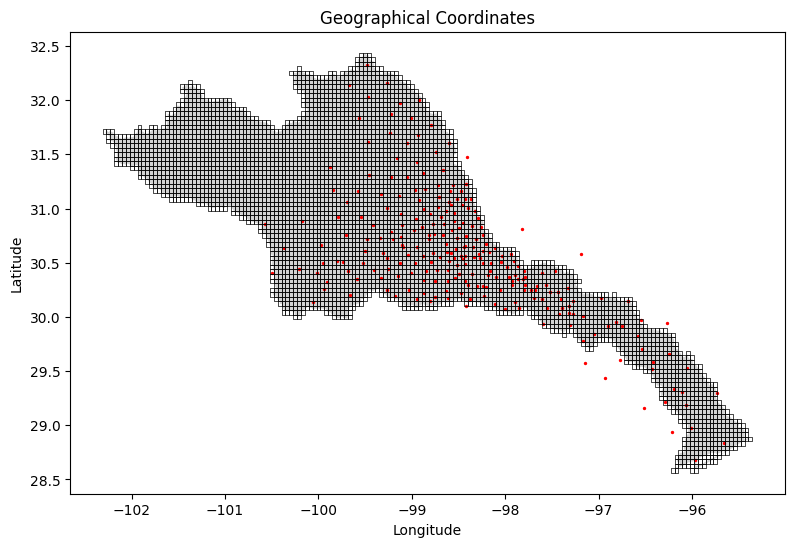

In [9]:
def get_centroid_and_plot(LCRA_shp_pth, prism_shape_file, prcp_coord):

    #Read and Reproject the world and grid map to EPSG:3857 (meters)
    world = gpd.read_file(LCRA_shp_pth)
    world = world.to_crs(epsg=3857)

    mesh_grid = gpd.read_file(prism_shape_file)
    mesh_grid = mesh_grid.to_crs(epsg=3857)

    # Perform the intersection
    intersected_mesh = gpd.sjoin(mesh_grid, world, how='inner', predicate='intersects')

    # Reproject the world and grid map to EPSG:4326
    intersected_mesh = intersected_mesh.to_crs(epsg=4326)
    world = world.to_crs(epsg=4326)

    #Plot world, mesh and prcp data
    base = world.plot(color='lightgray', figsize=(10, 6))
    intersected_mesh.boundary.plot(ax=base, edgecolor='black', linewidth=0.5)

    prcp_gdf = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in prcp_coord], crs="EPSG:4326")
    prcp_gdf.plot(ax=base, marker='o', color='red', markersize=2)

    plt.title('Geographical Coordinates')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Show the plot
    plt.show()
    
    # Calculate the centroids using an equal-area projection
    equal_area_crs = '+proj=cea'
    intersected_mesh['centroid_equal_area'] = intersected_mesh.to_crs(equal_area_crs).centroid.to_crs(intersected_mesh.crs)

    # Extract the coordinates of the centroids
    centroid_equal_area = intersected_mesh['centroid_equal_area'].apply(lambda point: (point.x, point.y)).tolist()

    centroid_points = gpd.GeoSeries([Point(xy) for xy in centroid_equal_area], crs=intersected_mesh.crs)
    centroids_shape_file_dir = "centroids_shape_file"
    centroids_shape_file_pth =os.path.join(centroids_shape_file_dir, "centroids_equal_area.shp")
    
    if not os.path.exists(centroids_shape_file_dir):
        os.makedirs(centroids_shape_file_dir)

    # Create a GeoDataFrame for the centroids
    centroids_gdf = gpd.GeoDataFrame(geometry=centroid_points)
    centroids_gdf.to_file(centroids_shape_file_pth, driver='ESRI Shapefile')

    # Extract x and y coordinates of centroids
    centroid_coords = np.array(centroid_equal_area)

    return centroid_coords, intersected_mesh

test_data_coords, intersected_mesh = get_centroid_and_plot(LCRA_shp_pth, prism_shape_file_4km, prcp_coord)

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

def plot_texas_and_LCRA(LCRA_shp_pth, prcp_coord):
    # Load the LCRA shapefile
    LCRA = gpd.read_file(LCRA_shp_pth).to_crs(epsg=4326)

    # Load a shapefile or a GeoDataFrame for Texas (replace with your Texas shapefile path if necessary)
    texas = gpd.read_file("/home/arvinder/Downloads/tl_2016_48_cousub/tl_2016_48_cousub.shp").to_crs(epsg=4326)

    # Create a figure for the Texas map with LCRA overlay
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot Texas
    texas.plot(ax=ax, color='lightgray', edgecolor='black')

    # Overlay the LCRA region
    LCRA.plot(ax=ax, color='lightblue', edgecolor='blue', alpha=0.5)

    # Customize the plot aesthetics
    plt.title('LCRA Region Overlay on Texas', fontsize=16, fontweight='bold')
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)

    # Show the plot
    plt.tight_layout()
    plt.show()

    # Create a second figure for the stations
    prcp_gdf = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in prcp_coord], crs="EPSG:4326")

    fig, ax = plt.subplots(figsize=(12, 8))
    LCRA.boundary.plot(ax=ax, color='blue', linewidth=1.2)

    # Plot the precipitation stations
    prcp_gdf.plot(ax=ax, color='red', marker='o', markersize=50, label='Precipitation Stations')

    # Add compass rose
    ax.annotate('', xy=(0.9, 0.9), xytext=(0.85, 0.85),
                arrowprops=dict(facecolor='black', shrink=0.05))
    ax.text(0.9, 0.9, 'N', fontsize=12, ha='center')

    # Customize the plot aesthetics
    plt.title('Precipitation Stations in LCRA Region', fontsize=16, fontweight='bold')
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function with the provided paths and coordinates
plot_texas_and_LCRA(LCRA_shp_pth, prcp_coord)


In [10]:
# Convert to numpy arrays
train_coords = np.array(list(prcp_dict.keys()))
train_values = list(np.array(prcp_data['Daily Rain (inches)']) for prcp_data in prcp_dict.values())
x_coords_train = np.array(train_coords[:, 1])   #  Longitude
y_coords_train = np.array(train_coords[:, 0])   #  Latitude
# Create an array of dates between start and end date
dates = np.arange(start_date, np.datetime64(end_date) + 1, dtype='datetime64[D]')

In [45]:
def init_kriging(dates, x_coords_train, y_coords_train, trn_values, test_data_coords, variogram_type='Exponential',
                  variance= 1, len_scale=0.9, kriging_type="Krige"):
    i = 0
    interpolated_vals = []
    interpolated_var = []

    variogram_models = {
        'Exponential': gs.Exponential,
        'Gaussian': gs.Gaussian,
        'Spherical': gs.Spherical
    }

    kriging_models = {
        'Krige': gs.krige.Krige,
        'Simple': gs.krige.Simple,
        'Ordinary': gs.krige.Ordinary,
        'Universal': gs.krige.Universal
    }

    for i in trange(len(dates), desc="Number of days"):   #len(dates)

        values = np.array([array[i] for array in trn_values])
        # Clean NaN and inf values
        valid_indices = ~np.isnan(values)
        x_coords_valid = np.array(x_coords_train)[valid_indices]
        y_coords_valid = np.array(y_coords_train)[valid_indices]
        values_valid = values[valid_indices]

        if len(values_valid) < 2:
            # Not enough valid points to perform interpolation
            interpolated_vals.append(np.full(test_data_coords.shape[0], np.nan))
            continue

        # Define a spatiotemporal variogram model
        variogram_class = variogram_models.get(variogram_type)
        model = variogram_class(dim=2, var=variance, len_scale=len_scale)

        # Create the kriging field
        kriging_class = kriging_models.get(kriging_type)
        krig = kriging_class(model, cond_pos=[x_coords_valid, y_coords_valid], cond_val=values_valid)

        # Perform the kriging
        field, variance_all = krig((test_data_coords[:, 0], test_data_coords[:, 1]))

        # Ensure non-negative values not present
        field[field < 0] = 0
        field = np.round(field, 2)
        interpolated_vals.append(field)
        interpolated_var.append(variance_all)

    return interpolated_vals

In [46]:
def init_rbf(dates, x_coords_train, y_coords_train, train_values, test_data_coords, fn_type="thin_plate"):
    i = 0
    interpolated_vals = []
    
    for i in trange(len(dates), desc="Number of days"): #len(dates)
        # Extract the values for the current date
        
        values = np.array([array[i] for array in train_values])

        # Clean NaN and inf values
        valid_indices = ~np.isnan(values)
        x_coords_valid = np.array(x_coords_train)[valid_indices]
        y_coords_valid = np.array(y_coords_train)[valid_indices]
        values_valid = values[valid_indices]
        
        if len(values_valid) < 2:
            # Not enough valid points to perform interpolation
            interpolated_vals.append(np.full(test_data_coords.shape[0], np.nan))
            continue
        
        # Perform RBF interpolation using thin plate smoothing
        rbf_interpolator = Rbf(x_coords_valid, y_coords_valid, values_valid, function=fn_type)
        
        # Compute interpolated values at the centroid coordinates
        field = rbf_interpolator(test_data_coords[:, 0], test_data_coords[:, 1])
        
        # Ensure non-negative values not present
        field[field < 0] = 0
        field = np.round(field, 2)
        
        interpolated_vals.append(field)
    return interpolated_vals

In [47]:
def idw_interpolation(dates, x_coords_train, y_coords_train, train_values, test_data_coords, power=2):
    interpolated_vals = []

    for i in trange(len(dates), desc="Number of days"):
        # Extract the values for the current date
        values = np.array([array[i] for array in train_values])

        # Clean NaN and inf values
        valid_indices = ~np.isnan(values)
        x_coords_valid = np.array(x_coords_train)[valid_indices]
        y_coords_valid = np.array(y_coords_train)[valid_indices]
        values_valid = values[valid_indices]

        if len(values_valid) < 2:
            # Not enough valid points to perform interpolation
            interpolated_vals.append(np.full(test_data_coords.shape[0], np.nan))
            continue

        # Construct the k-d tree for quick nearest-neighbor lookup
        tree = cKDTree(np.c_[x_coords_valid, y_coords_valid])

        # Perform IDW interpolation
        field = []
        for point in test_data_coords:
            distances, indices = tree.query(point, k=len(x_coords_valid), p=2)  # p=2 corresponds to Euclidean distance
            weights = 1 / (distances ** power)
            weights /= weights.sum()  # Normalize weights
            interpolated_value = np.sum(weights * values_valid[indices])
            field.append(interpolated_value)

        field = np.array(field)
        
        # Ensure non-negative values are handled (if necessary)
        field[field < 0] = 0
        field = np.round(field, 2)
        
        interpolated_vals.append(field)
    
    return interpolated_vals


In [44]:
def init_interpolation(dates, x_coords_train, y_coords_train, train_values, test_data_coords, 
                       interp_type='kriging', variogram_type='Exponential', variance=1, 
                       len_scale=0.9, kriging_type='Krige', power=2, fn_type='thin_plate'):
    
    interpolated_vals = []

    for i in trange(len(dates), desc="Number of days"):
        # Extract the values for the current date
        values = np.array([array[i] for array in train_values])

        # Clean NaN and inf values
        valid_indices = ~np.isnan(values)
        x_coords_valid = np.array(x_coords_train)[valid_indices]
        y_coords_valid = np.array(y_coords_train)[valid_indices]
        values_valid = values[valid_indices]

        if len(values_valid) < 2:
            # Not enough valid points to perform interpolation
            interpolated_vals.append(np.full(test_data_coords.shape[0], np.nan))
            continue

        if interp_type == 'kriging':
            # Define a spatiotemporal variogram model
            variogram_class = {
                'Exponential': gs.Exponential,
                'Gaussian': gs.Gaussian,
                'Spherical': gs.Spherical
            }.get(variogram_type)

            model = variogram_class(dim=2, var=variance, len_scale=len_scale)

            # Create the kriging field
            kriging_class = {
                'Krige': gs.krige.Krige,
                'Simple': gs.krige.Simple,
                'Ordinary': gs.krige.Ordinary,
                'Universal': gs.krige.Universal
            }.get(kriging_type)

            krig = kriging_class(model, cond_pos=[x_coords_valid, y_coords_valid], cond_val=values_valid)

            # Perform the kriging
            field, _ = krig((test_data_coords[:, 0], test_data_coords[:, 1]))

            # Ensure non-negative values
            field[field < 0] = 0
            field = np.round(field, 2)
            interpolated_vals.append(field)

        elif interp_type == 'rbf':
            # Perform RBF interpolation
            rbf_interpolator = Rbf(x_coords_valid, y_coords_valid, values_valid, function=fn_type)
            field = rbf_interpolator(test_data_coords[:, 0], test_data_coords[:, 1])

            # Ensure non-negative values
            field[field < 0] = 0
            field = np.round(field, 2)
            interpolated_vals.append(field)


        elif interp_type == 'idw':
            # Construct the k-d tree for quick nearest-neighbor lookup
            tree = cKDTree(np.c_[x_coords_valid, y_coords_valid])
            field = []
            # Perform IDW interpolation
            for point in test_data_coords:
                distances, indices = tree.query(point, k=len(x_coords_valid), p=2)  # p=2 for Euclidean distance
                weights = 1 / (distances ** power)
                weights /= weights.sum()  # Normalize weights
                interpolated_value = np.sum(weights * values_valid[indices])
                field.append(interpolated_value)

            field = np.array(field)

            # Ensure non-negative values
            field[field < 0] = 0
            field = np.round(field, 2)
            interpolated_vals.append(field)
        
        else:
            raise ValueError("Not a correct interpolation type. Choose between 'kriging', 'idw', and 'rbf'.")

    return interpolated_vals

In [12]:
def plot_interpolated_data(day_to_plt, intersected_mesh, interpolated_vals):
    # Plotting
    _, ax = plt.subplots(figsize=(10, 8))
    intersected_mesh.plot(ax=ax, facecolor='none', edgecolor='blue')  # Plot the original geometries for reference

    # Plot centroids with color representing precipitation values
    ax.scatter(test_data_coords[:, 0], test_data_coords[:, 1], c=interpolated_vals[day_to_plt], cmap='viridis', s=50, alpha=0.8, vmin=0)
    plt.title('Precipitation at Centroids')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

In [13]:
def find_closest_point(given_latlon, lat_list, lon_list):
    closest_point_id = None
    min_distance = float('inf')
    
    for loc_id, (lat, lon) in enumerate(zip(lat_list, lon_list)):
        point = (lat, lon)
        distance = geodesic(given_latlon, point).kilometers
        if distance < min_distance:
            min_distance = distance
            closest_point_id = loc_id
            closest_point = (lat, lon)    

    return closest_point_id, closest_point    

In [13]:
#  Randomly sample 20% points for validation
sample_size = 0.2

validation_x_coords, validation_y_coords, validation_values, train_x_coords, train_y_coords, train_values_sampled = sample_points(x_coords_train, y_coords_train, train_values, sample_size)

In [38]:
# Perform Kriging and store new interpolated vals
interp_vals_krig = init_interpolation(dates, train_x_coords, train_y_coords, train_values_sampled, test_data_coords, 
                                                          interp_type="kriging")


Number of days: 100%|██████████| 6148/6148 [00:00<00:00, 29985.90it/s]

(197, 6148)


In [ ]:
# Find the closest point to the radomly sampled validation points
closest_points = []
for i in trange(len(validation_x_coords), desc="Closest points"):
    clst_pt = find_closest_point((validation_y_coords[i], validation_x_coords[i]), test_data_coords[:, 1], test_data_coords[:, 0])
    closest_points.append(clst_pt)

In [39]:
def validation_analysis(sampled_interpolated_vals, validation_values, closest_pts_id, 
                        dates, closest_points, helping_str, validation_sites):
    i = 0
    new_vals = np.vstack(sampled_interpolated_vals)
    r_sq_list = []
    mae_list = []
    rmse_list = []
    mse_list = []
    j = 0
    for ran_val in validation_values:
        site_name = validation_sites[j][:-10]
        j += 1
        observed = ran_val[:]
        predicted = new_vals[:, closest_pts_id[i]]
        lat, lon = closest_points[i]
        data = {
            "Date": dates,
            "Latitude": [lat] * len(dates),  # Repeat the single latitude
            "Longitude": [lon] * len(dates),  # Repeat the single longitude
            "Observed": observed,
            helping_str: predicted
        }

        df = pd.DataFrame(data)
        directory = os.path.join("/home/arvinder/interpolation/LCRA-Interpolation/interpolation_results_12-12", helping_str)
        os.makedirs(directory, exist_ok=True)
        df.to_csv(os.path.join(directory, f'{site_name}.csv'), index=False)

        # Filter out NaN values
        valid_mask =  ~np.isnan(observed) & ~np.isnan(predicted)
        observed_filtered = observed[valid_mask]
        predicted_filtered = predicted[valid_mask]
        i += 1
        if observed_filtered.size > 0 and predicted_filtered.size > 0:
            r_squared = r2_score(observed_filtered, predicted_filtered)
            mae = mean_absolute_error(observed_filtered, predicted_filtered)
            rmse = root_mean_squared_error(observed_filtered, predicted_filtered)
            mse = mean_squared_error(observed_filtered, predicted_filtered)

            r_sq_list.append(r_squared)
            mae_list.append(mae * 25.4)    # inch to mm
            rmse_list.append(rmse)
            mse_list.append(mse)

    return r_sq_list, mae_list, rmse_list, mse_list

In [ ]:
def plot_histogram(analyzed_data_list, type_of_data):
    interval = 0.1
    bin_edges = np.arange(min(analyzed_data_list) - interval, max(analyzed_data_list) + interval, interval)

    # Create histogram
    plt.hist(analyzed_data_list, bins=bin_edges, edgecolor='black')

    # Add labels and title
    plt.xlabel(type_of_data)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {type_of_data} with {interval} Intervals')

    # Show plot
    plt.show()

plot_histogram(r_sq_list, "R-square")
plot_histogram(mae_list, "MAE")

In [15]:
def plot_rsq(intersected_mesh, r_sq_list, validation_x_coords, validation_y_coords):
    # Plotting
    _, ax = plt.subplots(figsize=(10, 8))
    intersected_mesh.plot(ax=ax, facecolor='none', edgecolor='black')  # Plot the original geometries for reference

    for idx, r_sw in enumerate(r_sq_list):
        if r_sw > 0.5:
            # Create the scatter plot
            ax.scatter(validation_x_coords[idx], validation_y_coords[idx], color="green")
        if 0.3 < r_sw <= 0.5:
            # Create the scatter plot
            ax.scatter(validation_x_coords[idx], validation_y_coords[idx], color="yellow")
        if 0.3 >= r_sw :
            # Create the scatter plot
            ax.scatter(validation_x_coords[idx], validation_y_coords[idx], color="red")
        if r_sw < 0:
            ax.scatter(validation_x_coords[idx], validation_y_coords[idx], color="Black")

    plt.title('Scatter Plot of R^2 Values with Custom Red-Yellow-Green Colormap')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()
# plot_rsq(intersected_mesh, r_sq_list, validation_x_coords, validation_y_coords)

In [15]:
#  Density vs different interpolation techniques
def get_distance(coordinates):
    distances = []
    for i in range(len(coordinates)):
        for j in range(i + 1, len(coordinates)):
            dist = geodesic(coordinates[i], coordinates[j]).km
            distances.append(dist)

    average_distance = np.mean(distances)
    return average_distance


def resample_points(coords, val, target_distance):
    # Start with the first coordinate as a selected point
    selected_points = [coords[0]]
    selected_vals = [val[0]]
    validation_points = []
    validation_vals = []
    # Iterate through the remaining points
    for i , point in enumerate(coords[1:]):
        # Calculate the average distance from the current point to all selected points
        avg_distance_to_selected = np.mean([
            geodesic(point, selected_point).km
            for selected_point in selected_points
        ])

        # If the average distance is greater than or equal to the target, select the point
        if avg_distance_to_selected >= target_distance:
            selected_points.append(point)
            selected_vals.append(val[i + 1])
        else:
            validation_points.append(point)
            validation_vals.append(val[i + 1])

    # Return the selected points as a numpy array
    return np.array(selected_points), np.array(selected_vals)

In [16]:
def sample_points(x_coords_train, y_coords_train, train_values, sample_sz, site_names, seed=10):
    # Convert inputs to numpy arrays if they are not already
    x_coords_train = np.array(x_coords_train)
    y_coords_train = np.array(y_coords_train)
    train_values = np.array(train_values)
    site_names = np.array(site_names)
    
    # Ensure all inputs have the same length
    assert len(x_coords_train) == len(y_coords_train) == len(train_values), "Input arrays must have the same length"
    
    # Get total number of points
    total_points = len(train_values)

    # Ensure sample_sz is an integer
    sample_sz = int(sample_sz * total_points)
    if seed is not None:
        np.random.seed(seed)
    
    # Shuffle the indices to randomly sample points
    shuffled_indices = np.random.permutation(total_points)
    
    # Split the shuffled indices for validation and training
    validation_indices = shuffled_indices[:sample_sz]
    train_indices_sampled = shuffled_indices[sample_sz:]

    # Select validation points
    validation_x_coords = x_coords_train[validation_indices]
    validation_sites = site_names[validation_indices]
    validation_y_coords = y_coords_train[validation_indices]
    validation_values = train_values[validation_indices]
    
    # Select remaining sampled training points
    train_x_coords_sampled = x_coords_train[train_indices_sampled]
    train_y_coords_sampled = y_coords_train[train_indices_sampled]
    train_values_sampled = train_values[train_indices_sampled]
    
    return (validation_x_coords, validation_y_coords, validation_values, 
            train_x_coords_sampled, train_y_coords_sampled, train_values_sampled, validation_sites)


In [17]:
# Combine x and y coordinates into pairs

sample_size = 0.2

validation_x_coords, validation_y_coords, validation_values, train_x_coords, train_y_coords, train_values_sampled, validation_sites = sample_points(x_coords_train, y_coords_train, train_values, sample_size, site_names)
coordinates = list(zip(train_y_coords, train_x_coords))

# Distance before sampling
average_distance = get_distance(coordinates)

In [ ]:
print(f"Density: {get_distance(resampled_pts)/average_distance}")
print(f"Distance before: {average_distance}, Distance after: {get_distance(resampled_pts)}")

In [ ]:
r_sq_list = [ 0 ] * len(train_x_coords)
plot_rsq(intersected_mesh, r_sq_list, train_x_coords, train_y_coords)

In [ ]:
r_sq_list = [ 0 ] * len(validation_x_coords)
plot_rsq(intersected_mesh, r_sq_list, validation_x_coords, validation_y_coords)

In [ ]:
samples_arr = [0.75, 0.8, 0.85, 0.9, 0.95, 1, 1.05, 1.10, 1.15, 1.20, 1.25, 1.30, 1.35, 1.4, 1.45, 1.50]
for sample_sz in samples_arr:
    target_distance = average_distance*sample_sz
    resampled_pts, train_values_resampled = resample_points(coordinates, train_values_sampled, target_distance)
    print(f"Density: {get_distance(resampled_pts)/average_distance}")
    print(f"Distance before: {average_distance}, Distance after: {get_distance(resampled_pts)}")

In [ ]:

variogram_models = {
        'Exponential': gs.Exponential,
        'Gaussian': gs.Gaussian,
        'Spherical': gs.Spherical
    }

kriging_models = {
    'Krige': gs.krige.Krige,
    'Simple': gs.krige.Simple,
}

results = []

samples_arr = ["init"]

for sample_sz in samples_arr:
    target_distance = average_distance
    if sample_sz != "init":
        target_distance = average_distance*sample_sz
        resampled_pts, train_values_resampled = resample_points(coordinates, train_values_sampled, target_distance)
        train_y = resampled_pts[:, 0]
        train_x = resampled_pts[:, 1]

    for var_name, var_model in variogram_models.items():
        for krig_name, krig_model in kriging_models.items():
            if sample_sz == "init":
                interp_vals = init_kriging(dates, train_x_coords, train_y_coords, train_values_sampled, test_data_coords, variogram_type=var_name, kriging_type=krig_name)
            else:
                interp_vals = init_kriging(dates, train_x, train_y, train_values_resampled, test_data_coords, variogram_type=var_name, kriging_type=krig_name)

            closest_points = []
            closest_pt_id = []
            for i in trange(len(validation_x_coords), desc="Closest points"):
                clst_pt_id, clst_pt = find_closest_point((validation_y_coords[i], validation_x_coords[i]), test_data_coords[:, 1], test_data_coords[:, 0])
                closest_pt_id.append(clst_pt_id)
                closest_points.append(clst_pt)
            
            helping_str = str(var_name) + " " + str(krig_name)
            r_sq_list, mae_list, rmse_list, mse_list = validation_analysis(interp_vals, validation_values, closest_pt_id, 0.7, 
                                                                           dates, closest_points, helping_str, validation_sites) 
            # Store the results
            results.append({
                'Variogram Model': var_name,
                'Kriging Model': krig_name,
                'R square Mean': np.mean(r_sq_list),
                'MAE mean': np.mean(mae_list),
                'RMSE Mean': np.mean(rmse_list),
                'MSE Mean': np.mean(mse_list),
                'Distance between stations': target_distance
            })
        
results_df = pd.DataFrame(results)
# results_df.to_csv('kriging_results.csv', index=False)
print(results_df)

In [ ]:
results2 = []
rbf_fn_types = ['linear', 'thin_plate', "cubic", 'quintic', 'multiquadric', 'inverse_multiquadric', 'gaussian']
samples_arr = ["init"]


for sample_sz in samples_arr:
    target_distance = average_distance
    if sample_sz != "init":
        target_distance = average_distance*sample_sz
        resampled_pts, train_values_resampled = resample_points(coordinates, train_values_sampled, target_distance)
        train_y = resampled_pts[:, 0]
        train_x = resampled_pts[:, 1]

    for fun_type in rbf_fn_types:
        if sample_sz == "init":
            interp_vals = init_rbf(dates, train_x_coords, train_y_coords, train_values_sampled, test_data_coords, fn_type=fun_type)
        else:
            interp_vals = init_rbf(dates, train_x, train_y, train_values_resampled, test_data_coords, fn_type=fun_type)
        
        closest_points = []
        closest_pt_id = []
        for i in trange(len(validation_x_coords), desc="Closest points"):
            clst_pt_id, clst_pt = find_closest_point((validation_y_coords[i], validation_x_coords[i]), test_data_coords[:, 1], test_data_coords[:, 0])
            closest_pt_id.append(clst_pt_id)
            closest_points.append(clst_pt)

        helping_str = "RBF " + str(fun_type)
        r_sq_list, mae_list, rmse_list, mse_list = validation_analysis(interp_vals, validation_values, closest_pt_id, 0.7, 
                                                                        dates, closest_points, helping_str, validation_sites)
        # Store the results
        results2.append({
            'Model': "RBF",
            'Function type': fun_type,
            'R square Mean': np.mean(r_sq_list),
            'MAE mean': np.mean(mae_list),
            'RMSE Mean': np.mean(rmse_list),
            'MSE Mean': np.mean(mse_list),
            'Distance between stations': target_distance
        })
        
results2_df = pd.DataFrame(results2)
# results2_df.to_csv('RBF_results.csv', index=False)
print(results2_df)

In [ ]:
results3 = []

samples_arr = ["init"]
for sample_sz in samples_arr:
    target_distance = average_distance
    if sample_sz != "init":
        target_distance = average_distance*sample_sz
        resampled_pts, train_values_resampled = resample_points(coordinates, train_values_sampled, target_distance)
        train_y = resampled_pts[:, 0]
        train_x = resampled_pts[:, 1]

    if sample_sz == "init":
        interp_vals = idw_interpolation(dates, train_x_coords, train_y_coords, train_values_sampled, test_data_coords)
    else:
        interp_vals = idw_interpolation(dates, train_x, train_y, train_values_resampled, test_data_coords)
    closest_points = []
    closest_pt_id = []
    for i in trange(len(validation_x_coords), desc="Closest points"):
        clst_pt_id, clst_pt = find_closest_point((validation_y_coords[i], validation_x_coords[i]), test_data_coords[:, 1], test_data_coords[:, 0])
        closest_pt_id.append(clst_pt_id)
        closest_points.append(clst_pt)
    helping_str = "IDW"
    r_sq_list, mae_list, rmse_list, mse_list = validation_analysis(interp_vals, validation_values, closest_pt_id, 0.7, 
                                                                    dates, closest_points, helping_str, validation_sites)
        # Store the results
    results3.append({
        'Model': "IDW",
        'R square Mean': np.mean(r_sq_list),
        'MAE Mean': np.mean(mae_list),
        'RMSE Mean': np.mean(rmse_list),
        'MSE Mean': np.mean(mse_list),
        'Distance between stations': target_distance
    })
        
results3_df = pd.DataFrame(results3)
# results3_df.to_csv('IDW_results.csv', index=False)
print(results3_df)

In [45]:
def run_all_methods(dates, average_distance, coordinates, train_values_sampled, test_data_coords,
                    validation_x_coords, validation_y_coords, validation_values, validation_sites):
    
    results_krig = []
    results_rbf = []
    results_idw = []

    variogram_models = {
        'Exponential': gs.Exponential,
        'Gaussian': gs.Gaussian,
        'Spherical': gs.Spherical
    }

    kriging_models = {
        'Krige': gs.krige.Krige,
        'Simple': gs.krige.Simple,
    }

    rbf_fn_types = ['linear', 'thin_plate', "cubic", 'quintic', 'multiquadric', 'inverse_multiquadric', 'gaussian']

    distances_arr = ["init"]

    closest_points = []
    closest_pt_id = []
    for i in trange(len(validation_x_coords), desc="Closest points"):
        clst_pt_id, clst_pt = find_closest_point((validation_y_coords[i], validation_x_coords[i]), test_data_coords[:, 1], test_data_coords[:, 0])
        closest_pt_id.append(clst_pt_id)
        closest_points.append(clst_pt)

    for sample_sz in distances_arr:
        target_distance = average_distance
        if sample_sz != "init":
            target_distance = average_distance*sample_sz
            resampled_pts, train_values_resampled = resample_points(coordinates, train_values_sampled, target_distance)
            train_y = resampled_pts[:, 0]
            train_x = resampled_pts[:, 1]
        
        
        for var_name in variogram_models.keys():
            for krig_name in kriging_models.keys():
                if sample_sz == "init":
                    interp_vals_krig = init_interpolation(dates, train_x_coords, train_y_coords, train_values_sampled, test_data_coords, 
                                                          interp_type="kriging", variogram_type=var_name, kriging_type=krig_name)
                else:
                    interp_vals_krig = init_interpolation(dates, train_x, train_y, train_values_resampled, test_data_coords, 
                                                          interp_type="kriging", variogram_type=var_name, kriging_type=krig_name)
                
                helping_str_krig = str(var_name) + " " + str(krig_name)
                r_sq_list, mae_list, rmse_list, mse_list = validation_analysis(interp_vals_krig, validation_values, closest_pt_id, 
                                                                            dates, closest_points, helping_str_krig, validation_sites) 
                # Store the results
                results_krig.append({
                    'Variogram Model': var_name,
                    'Kriging Model': krig_name,
                    'R square Mean': np.mean(r_sq_list),
                    'MAE mean': np.mean(mae_list),
                    'RMSE Mean': np.mean(rmse_list),
                    'MSE Mean': np.mean(mse_list),
                    'Distance between stations': target_distance
                })
                print(results_krig)

        for fun_type in rbf_fn_types:
            if sample_sz == "init":
                interp_vals_rbf = init_interpolation(dates, train_x_coords, train_y_coords, train_values_sampled, test_data_coords,
                                                      interp_type="rbf", fn_type=fun_type)
            else:
                interp_vals_rbf = init_interpolation(dates, train_x, train_y, train_values_resampled, test_data_coords,
                                                      interp_type="rbf", fn_type=fun_type)
            
            helping_str_rbf = "RBF " + str(fun_type)
            r_sq_list, mae_list, rmse_list, mse_list = validation_analysis(interp_vals_rbf, validation_values, closest_pt_id, 
                                                                            dates, closest_points, helping_str_rbf, validation_sites)
            # Store the results
            results_rbf.append({
                'Model': "RBF",
                'Function type': fun_type,
                'R square Mean': np.mean(r_sq_list),
                'MAE mean': np.mean(mae_list),
                'RMSE Mean': np.mean(rmse_list),
                'MSE Mean': np.mean(mse_list),
                'Distance between stations': target_distance
            })

        if sample_sz == "init":
            interp_vals = init_interpolation(dates, train_x_coords, train_y_coords, train_values_sampled, test_data_coords, interp_type="idw")
        else:
            interp_vals = init_interpolation(dates, train_x, train_y, train_values_resampled, test_data_coords, interp_type="idw")
        
        helping_str_idw = "IDW"
        r_sq_list, mae_list, rmse_list, mse_list = validation_analysis(interp_vals, validation_values, closest_pt_id, 
                                                                        dates, closest_points, helping_str_idw, validation_sites)
        # Store the results
        results_idw.append({
            'Model': "IDW",
            'R square Mean': np.mean(r_sq_list),
            'MAE Mean': np.mean(mae_list),
            'RMSE Mean': np.mean(rmse_list),
            'MSE Mean': np.mean(mse_list),
            'Distance between stations': target_distance
        })
    
    results_krig = pd.DataFrame(results_krig)
    results_rbf = pd.DataFrame(results_rbf)
    results_idw = pd.DataFrame(results_idw)

    return results_krig, results_rbf, results_idw

In [47]:
results_krig, results_rbf, results_idw = run_all_methods(dates, average_distance, coordinates, train_values_sampled, test_data_coords,
                    validation_x_coords, validation_y_coords, validation_values, validation_sites)

results_krig.to_csv('/home/arvinder/interpolation/LCRA-Interpolation/interpolation_results_12-12/Krig_results.csv', index=False)
results_rbf.to_csv('/home/arvinder/interpolation/LCRA-Interpolation/interpolation_results_12-12/RBF_results.csv', index=False)
results_idw.to_csv('/home/arvinder/interpolation/LCRA-Interpolation/interpolation_results_12-12/IDW_results.csv', index=False)

print(results_krig)
print(results_rbf)
print(results_idw)

Number of days: 100%|██████████| 6148/6148 [12:52<00:00,  7.96it/s]


  Model  R square Mean  MAE Mean  RMSE Mean  MSE Mean  \
0   IDW       0.741626  1.106224   0.179897  0.043158   

   Distance between stations  
0                 131.918502  


In [129]:
prism_data_path = "/home/arvinder/Downloads/clipped_rasters"
sorted_files = sorted(os.listdir(prism_data_path))
prism_data_list = []
max_val = 0
for file in sorted_files:

    # Read the TIFF file
    tiff_file = os.path.join(prism_data_path, file)

    with rasterio.open(tiff_file) as src:
        
        # Read the dataset's first band
        tiff_data = src.read()  # Reading the first band, for grayscale or single-band imagery
        coords = validation_x_coords[0], validation_y_coords[0]
        pixel_coords = [src.index(validation_x_coords, validation_y_coords)]
        pixel_values = [src.read(1)[row, col] for row, col in pixel_coords]
        if np.max(pixel_values[0]) > max_val:
            max_val = np.max(pixel_values[0])
            file_nm = file
        prism_data_list.append(pixel_values[0])

prism_grided = np.vstack(prism_data_list)


In [130]:
prism_df = pd.DataFrame(prism_grided)

# Generate a date range starting from 1985-01-01 with as many rows as the DataFrame
start_date_prism = '1985-01-01'
start_date = '2007-01-01'
end_date = '2023-10-31'
date_range = pd.date_range(start=start_date_prism, periods=len(prism_df), freq='D')
prism_df.index = date_range
df_filtered = prism_df.loc[start_date:end_date]

In [ ]:
ind = 0
r_sq_prism = []
mae_prism = []
i = 0
for m in trange(len(validation_values), desc="test"):
    valid_val = validation_values[m]
    observed_prism = df_filtered.iloc[:, ind]
    observed_hydromet = valid_val
    valid_mask =  ~np.isnan(observed_prism) & ~np.isnan(observed_hydromet)
    observed_prism = list(observed_prism[valid_mask])
    observed_hydromet = observed_hydromet[valid_mask] * 25.4
    i += 1
    # print(observed_hydromet, observed_prism)
    
    if observed_hydromet.size > 0 and len(observed_prism) > 0:
        r_squared = r2_score(observed_hydromet, observed_prism)
        mae = mean_absolute_error(observed_hydromet, observed_prism)
        r_sq_prism.append(r_squared)
        mae_prism.append(mae)
    ind += 1

prism_comp_df = pd.DataFrame()
prism_comp_df["Station"] = validation_sites
prism_comp_df["R Square"] = r_sq_prism
prism_comp_df["MAE"] = mae_prism

print(prism_comp_df)
print(F"Mean R-square PRISM vs Hydromet {np.mean(r_sq_prism)}")
print(F"Mean MAE PRISM vs Hydromet {np.mean(mae_prism)}")

In [ ]:
interpolated_vals = idw_interpolation(dates, x_coords_train, y_coords_train, train_values, test_data_coords)

In [33]:
for i in range(len(dates)):
    raster_data = {
    "latitude": test_data_coords[:, 1],
    "longitude": test_data_coords[:, 0],
    "value": interpolated_vals[i]
    }

    # Convert to GeoDataFrame
    gdf = gpd.GeoDataFrame(raster_data, geometry=gpd.points_from_xy(raster_data['longitude'], raster_data['latitude']))

    # Define the grid resolution (4km x 4km)
    grid_size = 0.041666666667  # 4km in degrees

    # Define the bounds of the raster
    minx, miny, maxx, maxy = gdf.total_bounds
    width = int(np.ceil((maxx - minx) / grid_size))
    height = int(np.ceil((maxy - miny) / grid_size))

    # Create an empty raster
    raster = np.full((height, width), np.nan, dtype=np.float32)  # Initialize with NaNs to identify empty cells

    # Calculate the transform
    transform = from_origin(minx, maxy, grid_size, grid_size)
    crs = CRS.from_epsg(4326)  # Assuming WGS84

    # Fill the raster with values
    for _, row in gdf.iterrows():
        rowx = int((row.geometry.x - minx) / grid_size)
        rowy = int((maxy - row.geometry.y) / grid_size)
        if 0 <= rowx < width and 0 <= rowy < height:  # Ensure indices are within bounds
            if np.isnan(raster[rowy, rowx]):
                raster[rowy, rowx] = row['value']
            else:
                # Handle multiple points in the same cell; here we take the average
                raster[rowy, rowx] = (raster[rowy, rowx] + row['value']) / 2
        else:
            print("Out of bounds")
        

    # Define the output raster file
    output_file = 'Interpolated_LCRA/interpolated_IDW_4km_'+ str(dates[i]) + '.tif'

    # Write the raster to a file
    with rasterio.open(
        output_file,
        'w',
        driver='GTiff',
        height=raster.shape[0],
        width=raster.shape[1],
        count=1,
        dtype=raster.dtype,
        crs=crs,  # WGS84 Latitude/Longitude
        transform=transform,
    ) as dst:
        dst.write(raster, 1)

In [ ]:
import netCDF4 as nc
from datetime import datetime

# Example data arrays
latitude = test_data_coords[:, 1]  # Latitude array
longitude = test_data_coords[:, 0]  # Longitude array
ppt_value = np.array(interpolated_vals)           # Values array (days x locations)

# Convert date strings to numeric time (days since a reference date)
time_units = f'days since {str(start_date)}'
time_calendar = 'gregorian'
date_objs = pd.to_datetime(dates).to_pydatetime()
time_values = nc.date2num(date_objs, units=time_units, calendar=time_calendar)

with nc.Dataset('LCRA_interpolated.nc', 'w', format='NETCDF4') as dataset:
    # Define dimensions
    dataset.createDimension('location', len(latitude))  # Single dimension for each unique location
    dataset.createDimension('time', len(dates))  # Time dimension

    # Create variables for latitude, longitude, time, and value
    lat_var = dataset.createVariable('latitude', 'f4', ('location',))  # Location-based latitudes
    lon_var = dataset.createVariable('longitude', 'f4', ('location',))  # Location-based longitudes
    time_var = dataset.createVariable('time', 'f8', ('time',))  # Time variable
    ppt_var = dataset.createVariable('Precipitation', 'f4', ('time', 'location'))  # Values at each location per time

    # Assign attributes to the variables
    lat_var.units = 'degrees_north'
    lon_var.units = 'degrees_east'
    time_var.units = time_units
    time_var.calendar = time_calendar
    ppt_var.units = 'inches'  # Replace with your unit

    # Write data to the variables
    lat_var[:] = latitude
    lon_var[:] = longitude
    time_var[:] = time_values
    ppt_var[:, :] = ppt_value  # Each time step's values for each location

    #  Add global attributes
    dataset.description = 'NetCDF file containing precipitation data'

    # Add min/max attributes for latitude and longitude
    dataset.min_latitude = np.min(latitude)
    dataset.max_latitude = np.max(latitude)
    dataset.min_longitude = np.min(longitude)
    dataset.max_longitude = np.max(longitude)

    # Add additional metadata if necessary
    dataset.source = 'Generated from Hydromet hourly data 7-7AM' 
    dataset.references = 'https://hydromet.lcra.org/'  

print("NetCDF file with unstructured grid created successfully!")


In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Open the NetCDF file
dataset = xr.open_dataset('LCRA_interpolated.nc')

# Access the latitude, longitude, and values
latitudes = dataset['latitude'].values
longitudes = dataset['longitude'].values
values = dataset['Precipitation'].isel(time=2).values  # Get values for the first day

# Create a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(longitudes, latitudes, c=values, cmap='viridis', edgecolor='k', s=50)
plt.colorbar(label='Values')  # Add a colorbar
plt.title('Values on Day 1')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Close the dataset
dataset.close()